In [31]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
import datalad.api as dl
import warnings
import nibabel as nib
from scipy.stats import ttest_rel
from statannotations.Annotator import Annotator

warnings.simplefilter('ignore')

In [2]:
!pip install openpyxl

## Load behavrioral data

In [24]:
pwd


'/data/rainville/dSutterlin/projects/isc_suggestions'

In [25]:
data_dir = '/data/rainville/Hypnosis_ISC/4D_data'
ana_files = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))
subjects = [os.path.basename(os.path.dirname(path)) for path in ana_files]
project_dir = '/data/rainville/dSutterlin/projects/isc_suggestions'

behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
APM_subjects = ['APM' + sub[4:] for sub in subjects] # make APMXX format instead of subXX


In [12]:
import func
import importlib
importlib.reload(func) 

phenotype= func.load_process_y(behav_path,APM_subjects)
phenotype.head()

,SHSS_score,mean_VAS_Nana_int,mean_VAS_ana_int,mean_VAS_Nhyper_int,mean_VAS_hyper_int,mean_VAS_Nana_UnP,mean_VAS_ana_UnP,mean_VAS_Nhyper_UnP,mean_VAS_hyper_UnP,raw_change_ANA,raw_change_HYPER,total_chge_pain_hypAna,Chge_hypnotic_depth,Mental_relax_absChange,Automaticity_post_ind,Abs_diff_automaticity,SHSS_groups,auto_groups
APM09,6.0,30.0,32.5,49.333333,49.5,25.0,25.0,31.0,36.5,1.25,2.833333,1.583333,27.0,0.0,50.0,-3.0,1,0
APM03,8.0,52.333333,42.0,48.666667,58.5,56.333333,42.5,45.666667,54.5,-12.083333,9.333333,21.416667,57.0,4.0,51.0,42.0,1,2
APM22,3.0,37.666667,38.5,34.666667,33.5,39.666667,44.5,40.333333,41.5,2.833333,0.0,-2.833333,40.396552,-12.0,0.0,20.431034,0,1
APM28,9.0,63.333333,49.0,73.0,86.0,64.333333,46.0,67.0,80.5,-16.333333,13.25,29.583333,73.5,-14.0,58.0,44.0,2,2
APM17,7.0,27.0,16.0,16.0,18.5,36.666667,48.0,51.666667,54.0,0.166667,2.416667,2.25,40.396552,18.0,33.5,-6.0,1,0


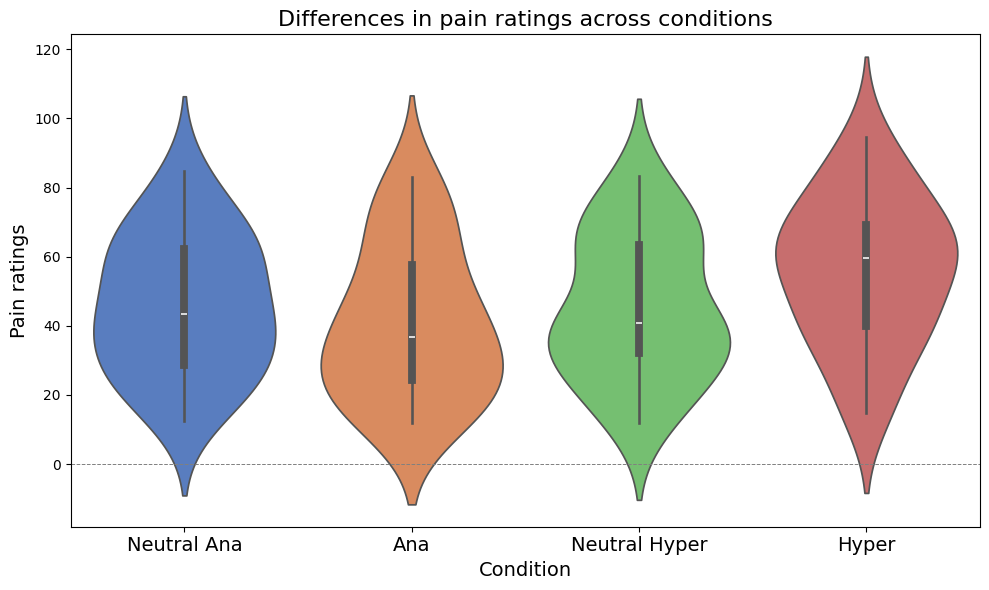

In [41]:
# Rename new columns
df['mean_VAS_Nana'] = (df['mean_VAS_Nana_int'] + df['mean_VAS_Nana_UnP']) / 2
df['mean_VAS_Ana'] = (df['mean_VAS_ana_int'] + df['mean_VAS_ana_UnP']) / 2
df['mean_VAS_NHyper'] = (df['mean_VAS_Nhyper_int'] + df['mean_VAS_Nhyper_UnP']) / 2
df['mean_VAS_Hyper'] = (df['mean_VAS_hyper_int'] + df['mean_VAS_hyper_UnP']) / 2

# Perform t-tests
t_nana_ana, p_nana_ana = ttest_rel(df['mean_VAS_Nana'], df['mean_VAS_Ana'])
t_nhyper_hyper, p_nhyper_hyper = ttest_rel(df['mean_VAS_NHyper'], df['mean_VAS_Hyper'])
t_hyper_ana, p_hyper_ana = ttest_rel(df['mean_VAS_Hyper'], df['mean_VAS_Ana'])

# Prepare data for plotting with updated names
plot_df = pd.melt(
    df[['mean_VAS_Nana', 'mean_VAS_Ana', 'mean_VAS_NHyper', 'mean_VAS_Hyper']],
    var_name='Condition',
    value_name='VAS'
)

# Map new condition names for the plot
plot_df['Condition'] = plot_df['Condition'].map({
    'mean_VAS_Nana': 'Neutral Ana',
    'mean_VAS_Ana': 'Ana',
    'mean_VAS_NHyper': 'Neutral Hyper',
    'mean_VAS_Hyper': 'Hyper'
})

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Condition', y='VAS', data=plot_df, inner='box', palette='muted')
plt.title('Differences in pain ratings across conditions', fontsize=16)
plt.ylabel('Pain ratings', fontsize=14)
plt.xlabel('Condition', fontsize=14)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)

# Add statistics as DataFrame
stats_df = pd.DataFrame({
    'Comparison': ['Neutral Ana vs Ana', 'Neutral Hyper vs Hyper', 'Hyper vs Ana'],
    't-value': [t_nana_ana, t_nhyper_hyper, t_hyper_ana],
    'p-value': [p_nana_ana, p_nhyper_hyper, p_hyper_ana],
    'Mean 1': [df['mean_VAS_Nana'].mean(), df['mean_VAS_NHyper'].mean(), df['mean_VAS_Hyper'].mean()],
    'Mean 2': [df['mean_VAS_Ana'].mean(), df['mean_VAS_Hyper'].mean(), df['mean_VAS_Ana'].mean()],
    'Significant': [p_nana_ana < 0.05, p_nhyper_hyper < 0.05, p_hyper_ana < 0.05]
})

output_path = os.path.join(project_dir, 'results', "behavioral_ttest_pain_ratings_violin.png")
plt.savefig(output_path, bbox_inches='tight')

plt.tight_layout()
plt.show()


### Save new behavioral dataframe

In [42]:
df.to_csv(os.path.join(project_dir, 'results', 'behavioral_data_cleaned.csv'), index = False)

<Figure size 640x480 with 0 Axes>

Load data